![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

**Asignatura:** *Deep Learning*

**Profesor:** Juan Bekios Calfa

**Fecha:** 03 de abril de 2024


---



# Laboratorio 2: Redes neuronales poco profundas y apredizaje

En este tutorial veremos dos implementaciones en Pytorch una con clasificación lineal multiclase y otra utilizando una red neuronal poco profunda. La idea es poder comparar el rendimiento de ambos clasificadores.

Como se verá, los modelos de entrenamiento implementados en Pytorch requieren mucho menos código que escribir un proyecto desde cero como se vió en el **Laboratorio 1**.

Sin embargo, Pytorch oculta muchos detalles en sus cálculos. Que serán estudiados aquí.

**Objetivos:**
- Estudiar el conjunto de base de datos MNIST, que contiene imágenes de $28\times 28$ píxeles escritos a mano.
- Introducir el uso de Pytorch para construir y entrenar modelos
- Explorar ajustes del modelo: Tamaño del conjunto de datos, tamaño del *batch* y regularización.

**Base de datos**

El conjunto de datos del MNIST contiene dígitos (numéricos) escritos a mano en blanco y negro de $28\times 28$ píxeles de tamaño. Este es un
conjunto de datos que se utiliza típicamente para demostraciones de modelos de aprendizaje de automático, y como un primer conjunto de datos para probar nuevos
tipos de modelos.

Para el laboratorio descargaremos este conjunto de datos.

In [1]:
from torchvision import datasets, transforms

# Transformar las imágenes PIL a tensores
transformar = transforms.Compose([
                                 transforms.ToTensor()
])

# Cargar el conjunto de datos de entrenamiento
mnist_train_all = datasets.MNIST('data', train=True, transform=transformar,download=True)

# Cargar el conjunto de datos de pruebas
mnist_test = datasets.MNIST('data', train=False, transform=transformar, download=True)

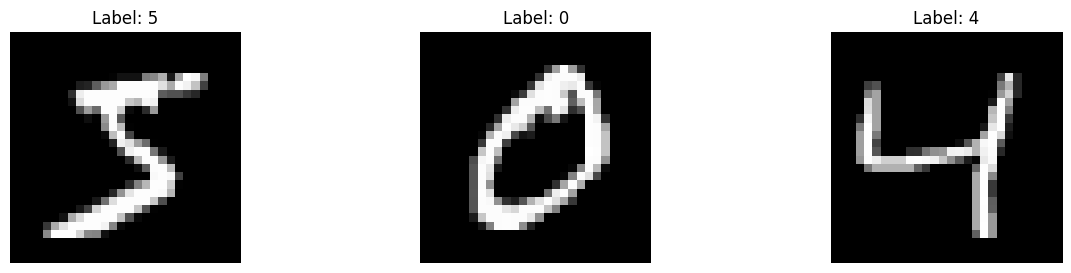

In [2]:
import matplotlib.pyplot as plt

# Mostrar las 10 primeras imágenes del conjunto de entrenamiento de MNIST
def show_mnist_images(dataset, num_images=10):
    # Crear una figura de matplotlib
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    # Iterar sobre las primeras num_images imágenes del dataset
    for i in range(num_images):
        # Obtener la i-ésima imagen y su etiqueta
        image, label = dataset[i]

        # Mostrar la imagen en el subplot correspondiente
        axes[i].imshow(image.squeeze(), cmap='gray')  # Utilizamos squeeze() para eliminar la dimensión de canal si existe
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')  # Apagar los ejes

    plt.show()

# Mostrar las 10 primeras imágenes del conjunto de entrenamiento de MNIST
show_mnist_images(mnist_train_all, num_images=3)

In [3]:
print('Conjunto de entrenamiento:')
print(mnist_train_all)
print(mnist_train_all.data.shape)
print(mnist_train_all.targets)

Conjunto de entrenamiento:
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([60000, 28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])


In [4]:
print('Conjunto de pruebas:')
print(mnist_test)
print(mnist_test.data.shape)
print(mnist_test.targets)

Conjunto de pruebas:
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([10000, 28, 28])
tensor([7, 2, 1,  ..., 4, 5, 6])


## 1. Visualizando y explorando los datos

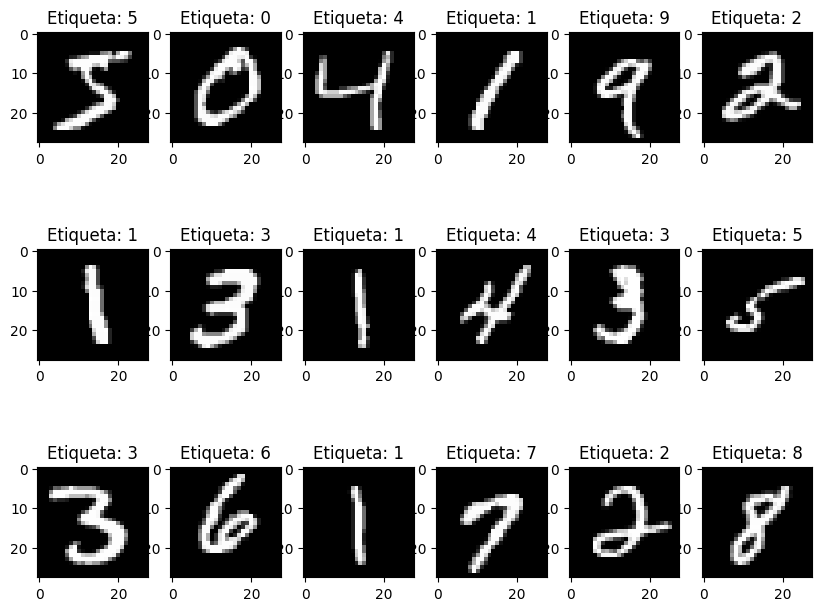

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for k, (image, label) in enumerate(zip(mnist_train_all.data[:18], mnist_train_all.targets[:18])):
  plt.subplot(3, 6, k+1)
  plt.title(f'Etiqueta: {label}')
  plt.imshow(image, cmap='gray')

PyTorch tiene funciones convertir una imagen en características numéricas de píxeles. El tensor aún conserva el 2D
geometría de la imagen (aún obtenemos una forma de $1\times 28\times 28$) y aún no aplana la imagen en un vector (para obtener un $1\times 784$
forma).

## 2. Preparando los datos

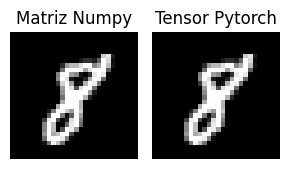

In [6]:
from torchvision import transforms

# Crear una figura y ejes utilizando subplot
fig, axes = plt.subplots(1, 2, figsize=(3, 2))

# convertir la última imagen vista (8) en formato tensor a numpy.
image_numpy = image.numpy()

# Mostrar la primera imagen en el primer conjunto de ejes
axes[0].imshow(image_numpy, cmap='gray')
axes[0].axis('off')  # Opcional: apagar los ejes
axes[0].set_title('Matriz Numpy')

# Volver a convertir a la imagen en un tensor (de numpy a tensor)
# Transformamos el tipo de dato de imagen a una matriz de 28x28
img_to_tensor = transforms.ToTensor()
img_tensor = img_to_tensor(image_numpy)

# Mostrar la segunda imagen en el segundo conjunto de ejes
axes[1].imshow(img_tensor[0], cmap='gray')
axes[1].axis('off')  # Opcional: apagar los ejes
axes[1].set_title('Tensor Pytorch')
#img_tensor.shape

# Ajustar el espacio entre las imágenes
plt.tight_layout()

Si queremos convertir la base de datos completa a representación de tipo Tensor. Se puede cargar de la siguiente forma:

In [7]:
print('Tamaño de la imagen',mnist_train_all.data[0].shape)

Tamaño de la imagen torch.Size([28, 28])


Ahora, dividiremos estos datos en entrenamiento y validación, y empezaremos a construir nuestro modelo. No necesitaremos un conjunto de pruebas, ya que fue cargado previsamente.

In [8]:
import torch
generador = torch.Generator().manual_seed(42)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_all, [50000, 10000], generator=generador)

In [9]:
print('Nuevo conjunto de entrenamiento:')
print(f'  Cantidad de instancias: {len(mnist_train)}')
print('Nuevo conjunto de validación:')
print(f' Cantidad de instancias: {len(mnist_val)}')

Nuevo conjunto de entrenamiento:
  Cantidad de instancias: 50000
Nuevo conjunto de validación:
 Cantidad de instancias: 10000


## 3. Modelo de clasificación lineal con Pytorch

Para construir un modelo lineal en PyTorch, crearemos una instancia de la clase `nn.Linear`, y especificamos el número de entrada y el número de características de salida. Para la regresión lineal y la clasificación binaria, el número de salida características es 1. Para la clasificación de clases múltiples, tenemos tantos resultados como clases hay.

Al usar este modelo para la clasificación, necesitaremos aplicar la activación sigmoide o softmax después. Es decir, este objeto sólo está destinado a manejar la parte lineal del cálculo del modelo.


In [10]:
import torch
import torch.nn as nn

example_model = nn.Linear(50, 1) # Asumimos 50 features y una salida lineal

El objeto `example_model` contiene los pesos y los sesgos de el modelo. Por defecto, PyTorch inicializa esos valores con números aleatorios cercanos a cero.

In [11]:
weight, bias = list(example_model.parameters())
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[ 0.0861,  0.0481,  0.0503,  0.0497, -0.0841,  0.1348,  0.0693, -0.1258,
          0.1163,  0.1343, -0.0483, -0.0032,  0.1222,  0.0821,  0.1301, -0.0646,
          0.1007,  0.0454, -0.0333,  0.0536, -0.0890, -0.1346,  0.0010, -0.0265,
         -0.0667,  0.0009, -0.0269,  0.0337, -0.0819,  0.1220, -0.0507, -0.0087,
         -0.0507, -0.0354,  0.0367, -0.0776,  0.0347, -0.0836, -0.0905,  0.0511,
         -0.0359,  0.0435, -0.0822, -0.0204,  0.1078, -0.1066, -0.0477,  0.0009,
          0.1036, -0.1124]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.0428], requires_grad=True)
torch.Size([1])


Si creamos un nuevo modelo, sus parametros iniciales cambiaran.

In [12]:
example_model = nn.Linear(50, 1)
weight, bias = list(example_model.parameters())

# Los valores son diferentes a los de arriba
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[ 0.0218,  0.0831, -0.1174,  0.0718, -0.0114, -0.0952, -0.1284, -0.0815,
          0.0740, -0.1217,  0.0709, -0.1377,  0.1219,  0.0584, -0.0210,  0.0135,
         -0.0296,  0.0503, -0.0563, -0.0453, -0.1321,  0.0532,  0.0497, -0.0377,
          0.1251,  0.0365, -0.0797,  0.1006,  0.1128,  0.0081,  0.0139,  0.0885,
         -0.1036, -0.0394, -0.0727,  0.0616,  0.0421,  0.0415, -0.1102,  0.0037,
         -0.1144,  0.0300, -0.1357, -0.0286, -0.0522, -0.1110,  0.0655, -0.1024,
         -0.1106,  0.0192]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.1139], requires_grad=True)
torch.Size([1])


### Modelo lineal multiclase

Ahora, vamos a crear el modelo real que entrenaremos para resolver el problema de clasificación de dígitos del MNIST. ¿Cuántos
características de entrada que tenemos? ¿Cuántas características de salida necesitamos?

In [13]:
model = nn.Linear(784, 10) # 784 = 28*28

# Verifiquemos que las formas de los pesos y los sesgos son lo que esperamos
weight, bias = list(model.parameters())
print(weight.shape)
print(bias.shape)

torch.Size([10, 784])
torch.Size([10])


## 4. Haciendo predicciones

Veamos cómo podemos hacer una predicción con este modelo. (Puede que parezca extraño que estemos hablando de cómo
hacer predicciones antes de hablar de cómo entrenar el modelo. La razón es que siempre entrenaremos el modelo
utilizando una variante de descenso de gradiente. Así que puedes imaginar que los pesos de este modelo se convertirán eventualmente en más
significativo de lo que es ahora)

Empezaremos con el modelo de ejemplo más simple primero. La forma en que hacemos las predicciones es comenzando con una entrada
x que tiene la forma requerida. Ya que `example_model` es sólo un ejemplo, crearemos un tensor con la apropiada forma, llena de valores aleatorios.

In [14]:
x = torch.randn(50) # Crear un tensor de rango 1 con 50 características
x.shape

torch.Size([50])

Para hacer predicciones, aplicamos el `example_model` como si fuera una función, con las entradas como argumento:

In [15]:
# Usamos, nuevamente el modelo de 50 entradas
y = example_model(x)
y

tensor([0.3816], grad_fn=<ViewBackward0>)

Si este modelo se utilizara para la **clasificación binaria**, también podríamos necesitar aplicar la función sigmoide:

In [16]:
torch.sigmoid(example_model(x))

tensor([0.5943], grad_fn=<SigmoidBackward0>)

Una buena noticia  de PyTorch es que vectoriza y paraleliza el cálculo para nosotros. Así que, si tuviéramos un lote de 32
entradas para las que queremos hacer predicciones, podemos realizar ese cálculo usando una sola llamada:

In [17]:
x = torch.randn([32, 50]) # pila de  32 entradas
print(x.shape)
y = example_model(x)
print(y)

torch.Size([32, 50])
tensor([[ 0.5390],
        [ 0.5307],
        [ 0.8510],
        [ 0.7088],
        [ 0.4854],
        [-0.3498],
        [ 0.6498],
        [-0.9012],
        [-0.1669],
        [-0.3325],
        [-0.7983],
        [ 0.1193],
        [-0.5468],
        [-0.4729],
        [ 1.1331],
        [ 0.4017],
        [ 0.4385],
        [ 0.4363],
        [ 0.8502],
        [-0.5143],
        [ 1.0244],
        [ 0.1627],
        [ 0.0513],
        [ 0.8616],
        [-1.0845],
        [ 0.2118],
        [-0.0409],
        [-0.4983],
        [-0.2098],
        [-0.2780],
        [ 0.6585],
        [-0.6612]], grad_fn=<AddmmBackward0>)


In [18]:
pred = torch.sigmoid(y)
print(pred > 0.5)

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False]])


(Nota: El orden de las dimensiones en nuestra entrada $x$ importa. El tamaño del *batch size* siempre va primero, y el número de características siempre va en segundo lugar) ¡Ahora, tratemos de hacer algunas "predicciones" con nuestro modelo MNIST! Todavía tenemos la variable image_tensor de
antes:

Text(0.5, 1.0, 'Etiqueta: 7 (torch.Size([1, 28, 28]))')

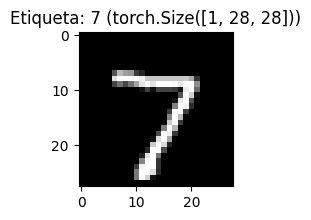

In [19]:
imagen, label = mnist_test[0] #Obtengo primera imagen

plt.figure(figsize=(3, 2))
plt.imshow(imagen[0], cmap='gray')
plt.title(f'Etiqueta: {label} ({imagen.size()})')

Sin embargo, la forma de este tensor no es lo que necesitamos que sea. Necesitamos aplanar la imagen en un rango 1
tensor (con forma [784]) o un tensor de rango 2 (con forma [1, 784]). Escogeremos este último, para que la transición a
pasar varias imágenes al mismo tiempo es más fácil:

In [20]:
# Creamos un modelo de 784 entradas y 10 salidas
model = nn.Linear(784, 10)

# Aplano la imagen
x = image.view(1, 784)
print(x.shape)

# Indicamos que los valores enteros de la imagen sean flotantes
z = model(x.to(torch.float32))
print(z)
print(z.shape)

y = torch.softmax(z, dim=1)
print('='*50)
print(f'Predicción: {y}') # "Probabilidad"
print('='*50)
print(f'Clasificación: {y.argmax()}')
print('='*50)

torch.Size([1, 784])
tensor([[  52.7044,  -33.2145,  -28.9312,  -40.1592,  -31.0530,   51.9414,
            0.1360, -101.1044,    5.0869,   11.5586]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 10])
Predicción: tensor([[6.8201e-01, 3.3088e-38, 2.3982e-36, 3.1888e-41, 2.8735e-37, 3.1799e-01,
         1.0083e-23, 0.0000e+00, 1.4249e-21, 9.2126e-19]],
       grad_fn=<SoftmaxBackward0>)
Clasificación: 0


El `dim=1` en el softmax le dice a PyTorch qué dimensión representa las diferentes imágenes, y cuál representa la
etiquetas de diferentes clases. Queremos que nuestros resultados sean una distribución de probabilidad entre las clases, y no las diferentes
imágenes.

## 5. Función de pérdida

Para que la red sea útil, necesitamos entrenarla, para que los pesos sean realmente significativos,
valores no aleatorios. Como se mencionó antes, usaremos la red para hacer predicciones, luego compararemos las predicciones
contra las observaciones reales a través de la función de pérdida.
PyTorch tiene funciones de pérdida estándar que podemos usar: por ejemplo, `nn.BCEWithLogitsLoss()` para una **clasificación binaria**
y un `nn.CrossEntropyLoss()` para un problema de **clasificación multiclase** como el nuestro.

In [21]:
criterion = nn.CrossEntropyLoss()

Este criterio también puede ser llamado como una función. Toma como parámetros la predicción de *logit* y las etiquetas reales, y
devuelve la pérdida. Dos cosas a tener en cuenta para esta función:

1. Las **funciones de pérdida** como esta normalmente toman el *logit* como parámetro, en lugar de las distribuciones de probabilidad post-softmax. Esto es para la estabilidad numérica.
2. Esta **función de pérdida** también toma como parámetro el índice de la etiqueta real, en lugar de un vector de un punto.

In [22]:
loss = criterion(y, torch.Tensor([8]).long()) # digit 8 = the 8-th class
print(y)
print(loss)

tensor([[6.8201e-01, 3.3088e-38, 2.3982e-36, 3.1888e-41, 2.8735e-37, 3.1799e-01,
         1.0083e-23, 0.0000e+00, 1.4249e-21, 9.2126e-19]],
       grad_fn=<SoftmaxBackward0>)
tensor(2.4294, grad_fn=<NllLossBackward0>)


## 6. Optimización

PyTorch también calcula las derivadas para nosotros usando la diferenciación automática, de la cual (podríamos) hablar en este curso.
En resumen, podemos especificar un optimizador (como el Descenso de Gradiente Estocástico), y usar el optimizador para determinar cómo
actualizar los pesos.

In [23]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.005) # lr = learning rate
# Tres líneas de código que son requeridas para el rendimiento
# de actualización del descenso de gradiente:
loss.backward() # Calcula los gradientes
optimizer.step() # Hace las actualizaciones de cada parámetro
optimizer.zero_grad() # Limpia el paso anterior dejado por step()

También podemos utilizar regularización L2 para mantener el suavizado de los parámetros:

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.01)

## 7. Batching

Pytorch nos permite cargar los datos por lotes para implementar el descenso de gradiente estocástico.


In [25]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=32, # batch size
                                           shuffle=True) # Mezclar despues de cada epoch
for k, (xs, ts) in enumerate(train_loader):
  print(f'Iteración {k:05d}:')
  print(f'  Tamaño de los datos: {xs.shape}')
  print(f'  Tamaño de los etiquetas: {ts.shape}')

Iteración 00000:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00001:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00002:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00003:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00004:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00005:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00006:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00007:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Size([32])
Iteración 00008:
  Tamaño de los datos: torch.Size([32, 1, 28, 28])
  Tamaño de los etiquetas: torch.Siz

## 8. Código completo

In [26]:
def run_gradient_descent(model,
                      batch_size=64,
                      learning_rate=0.01,
                      weight_decay=0,
                      num_epochs=10):
  # Optimización
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  iters, losses = [], []
  iters_sub, train_acc, val_acc = [], [] ,[]
  train_loader = torch.utils.data.DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True)
  # ENTRENAMIENTO
  n = 0 # Número de iteraciones
  for epoch in range(num_epochs):
    for xs, ts in iter(train_loader):
      if len(ts) != batch_size:
        continue
      xs = xs.view(-1, 784) # Convertir la imagen en un vector
      zs = model(xs)
      loss = criterion(zs, ts) # Calcular el loss total
      loss.backward() # Calcular gradientes
      optimizer.step() # Actualizar parámetros
      optimizer.zero_grad() # Borrar todos los cálculos anteriores en Pytorch
      # save the current training information
      iters.append(n)
      losses.append(float(loss)/batch_size) # Calcular el loss promedio
      if n % 10 == 0:
        iters_sub.append(n)
        train_acc.append(get_accuracy(model, mnist_train))
        val_acc.append(get_accuracy(model, mnist_val))
      # increment the iteration number
      n += 1

  # plotting
  plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
  plt.plot(iters, losses, label="Entrenamiento")
  plt.xlabel("Iteraciones")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
  plt.plot(iters_sub, train_acc, label="Entrenamiento")
  plt.plot(iters_sub, val_acc, label="Validación")
  plt.xlabel("Iteraciones")
  plt.ylabel("Tasa de acierto")
  plt.legend(loc='best')
  plt.show()

  return model

def get_accuracy(model, data):
  loader = torch.utils.data.DataLoader(data, batch_size=500)
  correct, total = 0, 0
  for xs, ts in loader:
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # Obtener el índice de la clasificiación (logit)
    correct += pred.eq(ts.view_as(pred)).sum().item()
    total += int(ts.shape[0])
    return correct / total

Ahora podemos entrenar el modelo.

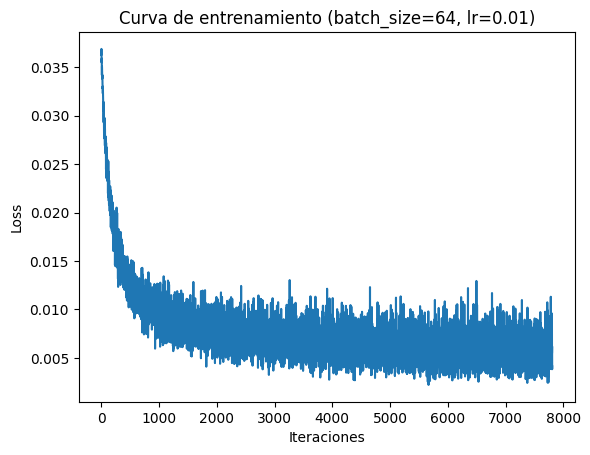

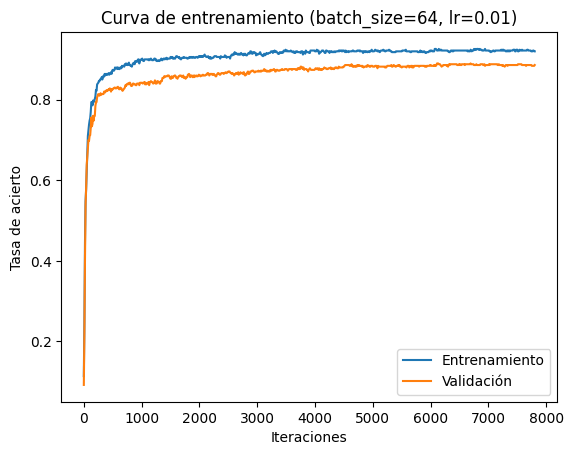

In [27]:
import time

# Medir el tiempo de inicio
start_time = time.time()

model = nn.Linear(784, 10)
run_gradient_descent(model, batch_size=64, learning_rate=0.01, num_epochs=10)

# Medir el tiempo de finalización
end_time = time.time()

In [28]:
# Calcular el tiempo de ejecución
execution_time = end_time - start_time

### Analizar vector de pesos

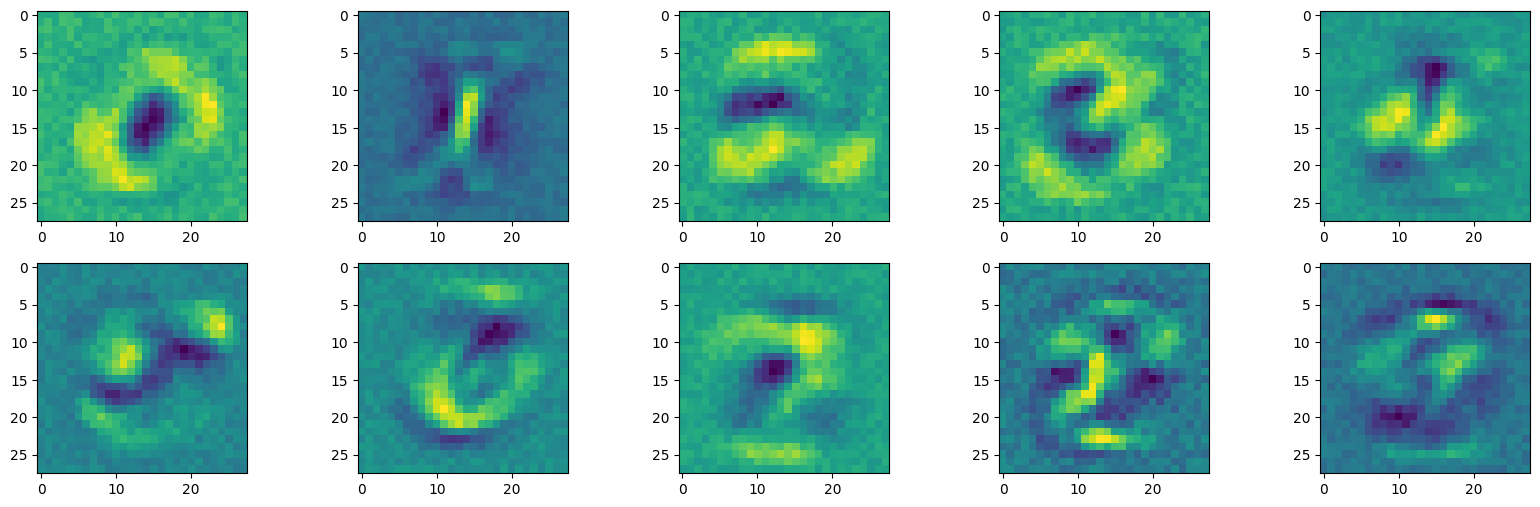

In [29]:
#print(list(model.parameters()))

#for name, param in model.named_parameters():
#    print(name)
#    print(param.shape)
#    print('-'*20)

# Obtengo los parámetros en formato diccionario
d = dict(model.named_parameters())
# Selecciono solo los parámetros que ajunta la regresión lineal
w = d['weight']
#print(d['weight'])

import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,6))
# Por cada vector de parámetros pesos grafico (10x728)
for index, template in enumerate(w):
  template = template.detach().numpy().reshape(28,28)
  plt.subplot(2, 5, index+1)
  plt.imshow(template)

# Entrega:

Para este laboratorio se pide utilizar un modelo neuronal de varias capas ocultas. La cantidad de neuronas por capa y la cantidad de capas ocultas deberán ser definidas por cada alumno.

Se pide en la plantilla Colab:

1.   Evaluar el modelo de clasificación lineal utilizando el conjunto de pruebas de MNIST. Utilice las métricas de tasa de acierto, precisión y recall.
2.   Entrenar un modelo neuronal con los datos de MNIST.
3.   Evaluar el modelo neuronal propuesto utilizando los datos de prueba de MNIST.
4.   Graficar los datos de la función de pérdida por iteración y la tasa de acierto.
5.   Comparar el modelo visto en clases vs el propuesto por usted. Utilice las métricas de tasa de acierto, precisión y recall.
6.   Comparar ambos modelos utilizando GPU.

Preparar un informe con los resultados obtenidos. Utilizar plantilla Latex y rúbrica suminitrada en clases.

## 1. Evaluar el modelo de clasificación lineal utilizando el conjunto de pruebas de MNIST.

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Función para evaluar el modelo
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    for xs, ts in data_loader:
        xs = xs.view(-1, 784)
        zs = model(xs)
        preds = zs.max(1, keepdim=True)[1]
        correct += preds.eq(ts.view_as(preds)).sum().item()
        all_preds.extend(preds.tolist())
        all_labels.extend(ts.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)

    return accuracy, precision, recall

# Evaluar el modelo en el conjunto de pruebas (mnist_test)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)
accuracy, precision, recall = evaluate_model(model, test_loader)

print(f'Tasa de Acierto: {accuracy:.4f}')

for i in range(10):  # 10 clases en MNIST
    print(f'Clase {i} - Precisión: {precision[i]:.4f}, Recall: {recall[i]:.4f}')

Tasa de Acierto: 0.9079
Clase 0 - Precisión: 0.9339, Recall: 0.9796
Clase 1 - Precisión: 0.9516, Recall: 0.9700
Clase 2 - Precisión: 0.9244, Recall: 0.8643
Clase 3 - Precisión: 0.8983, Recall: 0.8921
Clase 4 - Precisión: 0.8989, Recall: 0.9236
Clase 5 - Precisión: 0.8792, Recall: 0.8487
Clase 6 - Precisión: 0.9315, Recall: 0.9374
Clase 7 - Precisión: 0.9138, Recall: 0.8969
Clase 8 - Precisión: 0.8579, Recall: 0.8737
Clase 9 - Precisión: 0.8794, Recall: 0.8821


## 2. Entrenar un modelo neuronal con los datos de MNIST

ShallowNeuralNetwork(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


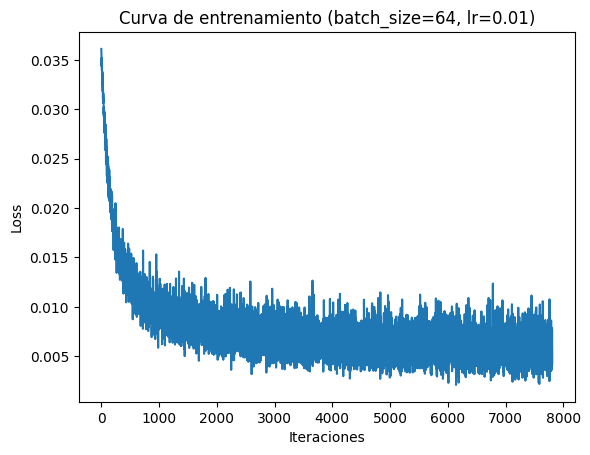

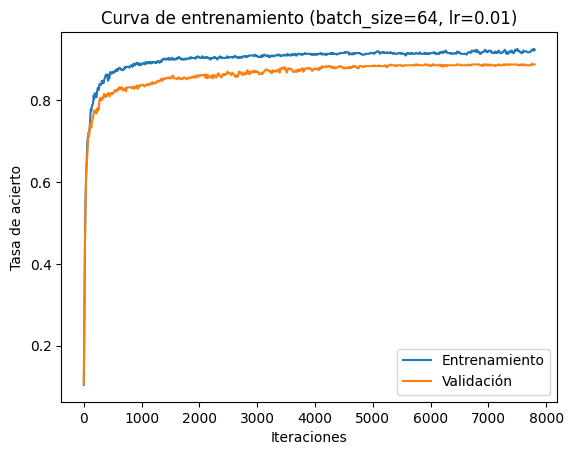

In [31]:
# Verificar la disponibilidad de CUDA y seleccionar el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modelo Propuesto
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_num, hidden_num) # Capa oculta
        self.output = nn.Linear(hidden_num, output_num) # Capa de salida
        self.relu = nn.ReLU() # relu Función de Activación

    def forward(self, x):
        x = self.relu(self.hidden(x))
        out = self.output(x)
        return nn.functional.softmax(out, dim=1)

input_num = 784
hidden_num = 128
output_num = 10

# Crear el modelo y enviarlo al dispositivo
model2 = ShallowNeuralNetwork(input_num, hidden_num, output_num)
model2.to(device)
print(model2)

start_time2 = time.time()

# Ejecutar el entrenamiento
model2 = nn.Linear(784, 10)
run_gradient_descent(model2, batch_size=64, learning_rate=0.01, num_epochs=10)

end_time2 = time.time()

In [32]:
# Calcular el tiempo de ejecución
execution_time2 = end_time2 - start_time2

##3. Evaluar el modelo neuronal propuesto utilizando los datos de prueba de MNIST.


In [33]:
## Código Aquí
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)
accuracy, precision, recall = evaluate_model(model2, test_loader)


print(f'Tasa de Acierto: {accuracy:.4f}')

for i in range(10):  # muestra los valores para cada clase
    print(f'Clase {i} - Precisión: {precision[i]:.4f}, Recall: {recall[i]:.4f}')

Tasa de Acierto: 0.9069
Clase 0 - Precisión: 0.9339, Recall: 0.9806
Clase 1 - Precisión: 0.9507, Recall: 0.9692
Clase 2 - Precisión: 0.9240, Recall: 0.8605
Clase 3 - Precisión: 0.8855, Recall: 0.9040
Clase 4 - Precisión: 0.8903, Recall: 0.9257
Clase 5 - Precisión: 0.9038, Recall: 0.8318
Clase 6 - Precisión: 0.9295, Recall: 0.9353
Clase 7 - Precisión: 0.9158, Recall: 0.8988
Clase 8 - Precisión: 0.8497, Recall: 0.8706
Clase 9 - Precisión: 0.8801, Recall: 0.8801


##4.   Graficar los datos de la función de pérdida por iteración y la tasa de acierto.


In [34]:
## Código Aquí
#El GRAFICO ESTA EN EL PUNTO 2

##5.   Comparar el modelo visto en clases vs el propuesto por usted. Utilice las métricas de tasa de acierto, precisión y recall.

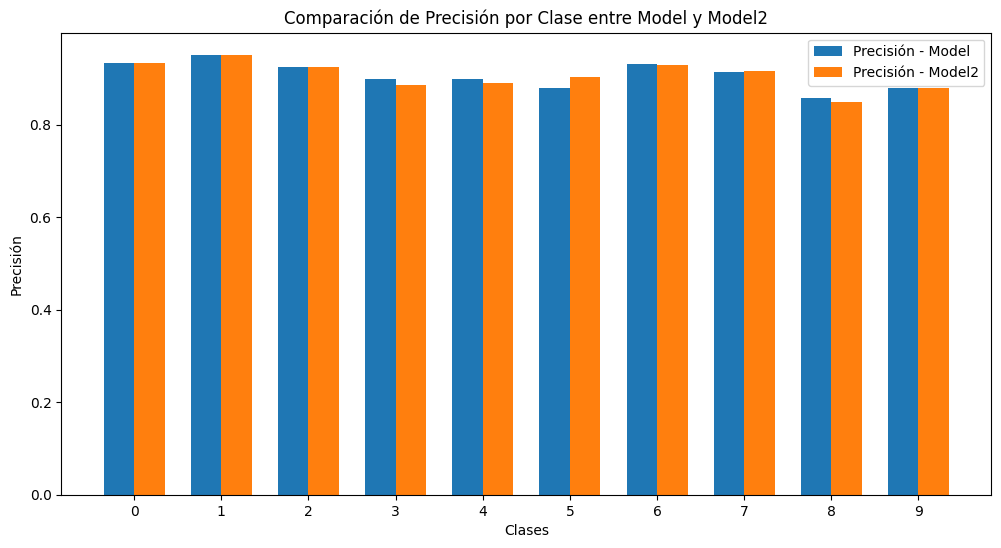

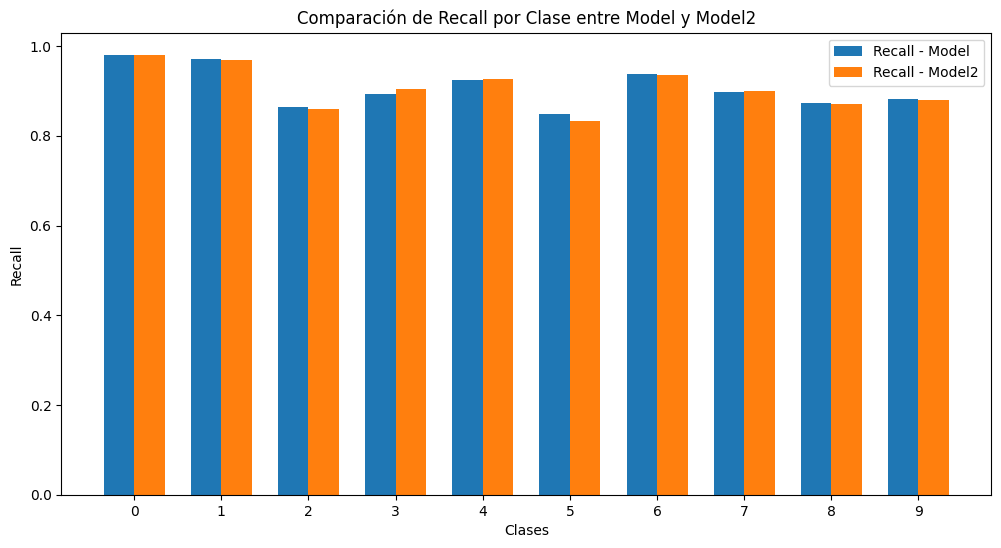

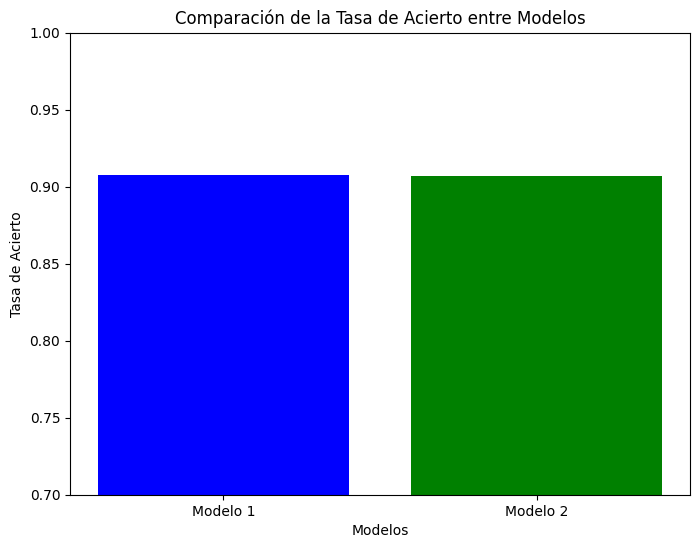

In [35]:
## Código Aquí
import matplotlib.pyplot as plt
import numpy as np

# Resultados de model
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)
accuracy, precision, recall = evaluate_model(model, test_loader)

# Resultados de model2
test_loader2 = torch.utils.data.DataLoader(mnist_test, batch_size=64)
accuracy2, precision2, recall2 = evaluate_model(model2, test_loader2)

# Clases de MNIST (0-9)
classes = [str(i) for i in range(10)]

# Precisión para model y model2
precision_model = [precision[i] for i in range(10)]
precision_model2 = [precision2[i] for i in range(10)]

# Recall para model y model2
recall_model = [recall[i] for i in range(10)]
recall_model2 = [recall2[i] for i in range(10)]

# Posiciones de las barras en el eje x
x = np.arange(len(classes))

# Ancho de las barras
bar_width = 0.35

# Crear el gráfico de barras para Precisión
fig, ax1 = plt.subplots(figsize=(12, 6))
bar1 = ax1.bar(x, precision_model, width=bar_width, label='Precisión - Model', align='center')
bar2 = ax1.bar(x + bar_width, precision_model2, width=bar_width, label='Precisión - Model2', align='center')

# Etiquetas de las clases en el eje x
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(classes)

# Títulos y leyendas
ax1.set_xlabel('Clases')
ax1.set_ylabel('Precisión')
ax1.set_title('Comparación de Precisión por Clase entre Model y Model2')
ax1.legend()

# Crear el gráfico de barras para Recall
fig, ax2 = plt.subplots(figsize=(12, 6))
bar3 = ax2.bar(x, recall_model, width=bar_width, label='Recall - Model', align='center')
bar4 = ax2.bar(x + bar_width, recall_model2, width=bar_width, label='Recall - Model2', align='center')

# Etiquetas de las clases en el eje x
ax2.set_xticks(x + bar_width / 2)
ax2.set_xticklabels(classes)

# Títulos y leyendas
ax2.set_xlabel('Clases')
ax2.set_ylabel('Recall')
ax2.set_title('Comparación de Recall por Clase entre Model y Model2')
ax2.legend()

# Mostrar los gráficos de barras
plt.show()

# Define las tasas de acierto de los dos modelos (reemplaza estos valores con los resultados reales)
accuracy_model1 = accuracy
accuracy_model2 = accuracy2

# Nombres de los modelos
model_names = ['Modelo 1', 'Modelo 2']

# Valores de las tasas de acierto
accuracy_values = [accuracy_model1, accuracy_model2]

# Crea el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_values, color=['blue', 'green'])
plt.xlabel('Modelos')
plt.ylabel('Tasa de Acierto')
plt.title('Comparación de la Tasa de Acierto entre Modelos')
plt.ylim(0.7, 1)  # Establece el rango del eje y si es necesario

# Muestra el gráfico
plt.show()

##6. Comparar ambos modelos utilizando GPU.

In [36]:
# Forzar el uso de la CPU
device = torch.device("cpu")

# Modelo Propuesto
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(ShallowNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_num, hidden_num) # Capa oculta
        self.output = nn.Linear(hidden_num, output_num) # Capa de salida
        self.relu = nn.ReLU() # relu Función de Activación

    def forward(self, x):
        x = self.relu(self.hidden(x))
        out = self.output(x)
        return nn.functional.softmax(out, dim=1)

input_num = 784
hidden_num = 128
output_num = 10

# Crear el modelo y enviarlo al dispositivo
model.to(device)
model2 = ShallowNeuralNetwork(input_num, hidden_num, output_num)
model2.to(device)
print(model2)

ShallowNeuralNetwork(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


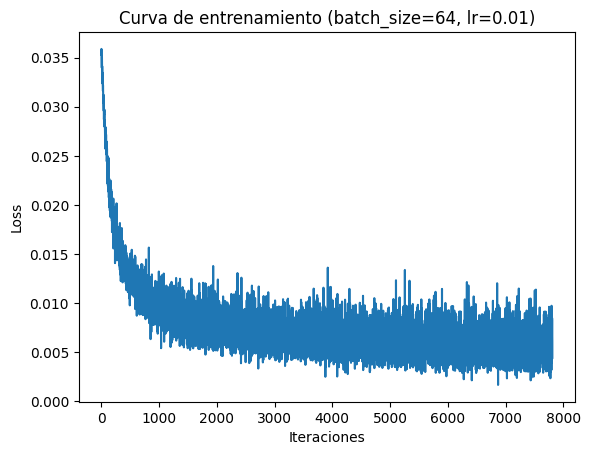

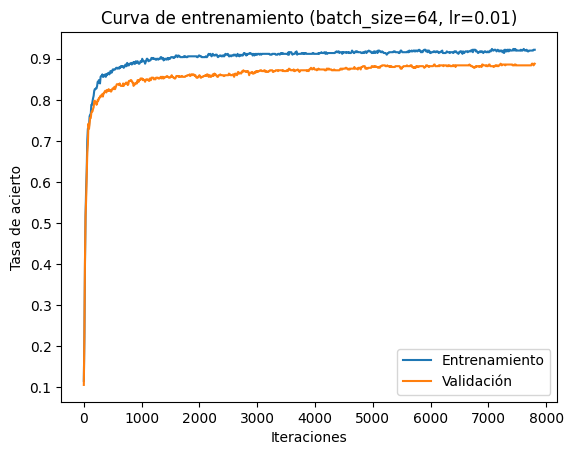

In [37]:
start_time3 = time.time()

# Ejecutar el entrenamiento
model2 = nn.Linear(784, 10)
run_gradient_descent(model2, batch_size=64, learning_rate=0.01, num_epochs=10)

end_time3 = time.time()

In [38]:
# Calcular el tiempo de ejecución
execution_time3 = end_time3 - start_time3

In [41]:
# Función de evaluación modificada para aplanar las imágenes
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xs, ts in test_loader:
            # Aplanar las imágenes
            xs = xs.view(xs.shape[0], -1)
            xs = xs.to(device)
            ts = ts.to(device)
            zs = model(xs)
            _, ys = torch.max(zs, 1)
            total += ts.size(0)
            correct += (ys == ts).sum().item()
    return correct / total

# Resultados de model en CPU
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)
model.to(device)  # Mover el modelo a la CPU
accuracy_cpu = evaluate_model(model, test_loader)

# Resultados de model2 en CPU
test_loader2 = torch.utils.data.DataLoader(mnist_test, batch_size=64)
model2.to(device)  # Mover el modelo a la CPU
accuracy2_cpu = evaluate_model(model2, test_loader2)


#Reporte

##1. Resultados

Usar tablas y gráficos para explicar los resultados obtenidos. Compare todos los modelos (CPU y GPU), tanto a nivel de modelos y eficiencia computacional (Espacial y temporal).

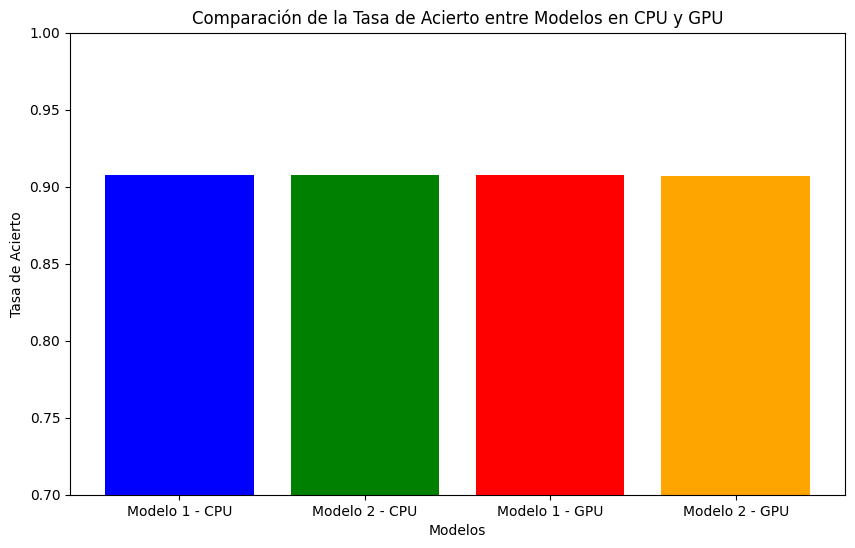

In [42]:
# Define las tasas de acierto de los dos modelos (reemplaza estos valores con los resultados reales)
accuracy_model1_cpu = accuracy_cpu
accuracy_model2_cpu = accuracy2_cpu

# Nombres de los modelos
model_names = ['Modelo 1 - CPU', 'Modelo 2 - CPU', 'Modelo 1 - GPU', 'Modelo 2 - GPU']

# Valores de las tasas de acierto
accuracy_values = [accuracy_model1_cpu, accuracy_model2_cpu, accuracy_model1, accuracy_model2]

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Modelos')
plt.ylabel('Tasa de Acierto')
plt.title('Comparación de la Tasa de Acierto entre Modelos en CPU y GPU')
plt.ylim(0.7, 1)  # Establece el rango del eje y si es necesario

# Muestra el gráfico
plt.show()

Podemos ver que los modelos no varían mucho en su tasa de acierto, independiente de su tipo de entrenamiento, esto es debido a que los procesos usados para entrenarlos son los mismos.

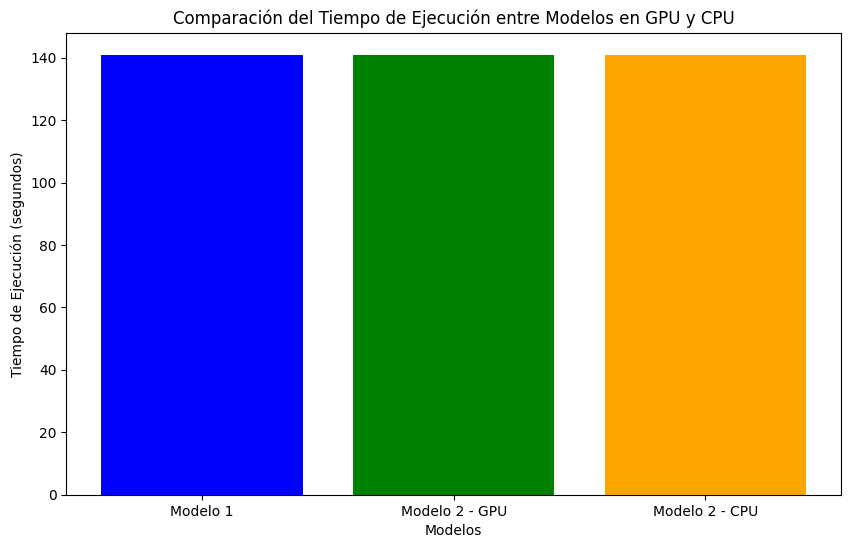

In [43]:
# Tiempos de ejecución de los modelos
execution_time_model1 = execution_time
execution_time_model2_gpu = execution_time2
execution_time_model2_cpu = execution_time3

# Nombres de los modelos
model_names = ['Modelo 1', 'Modelo 2 - GPU', 'Modelo 2 - CPU']

# Valores de los tiempos de ejecución
execution_times = [execution_time_model1, execution_time_model2_gpu, execution_time_model2_cpu]

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(model_names, execution_times, color=['blue', 'green', 'orange'])
plt.xlabel('Modelos')
plt.ylabel('Tiempo de Ejecución (segundos)')
plt.title('Comparación del Tiempo de Ejecución entre Modelos en GPU y CPU')

# Muestra el gráfico
plt.show()

##2. Conclusiones

Que puede deducir de los resultados obtenidos.